In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

C:\Users\two\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


You have TensorFlow version 1.10.0


In [3]:
data = pd.read_csv('../data/stack-overflow-data.csv')
data.shape

(40000, 2)

In [4]:
data.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


In [5]:
data['tags'].value_counts()

mysql            2000
jquery           2000
css              2000
ruby-on-rails    2000
javascript       2000
asp.net          2000
c++              2000
android          2000
python           2000
java             2000
php              2000
ios              2000
.net             2000
c#               2000
sql              2000
angularjs        2000
iphone           2000
objective-c      2000
c                2000
html             2000
Name: tags, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_posts ,test_posts, train_tags, test_tags = train_test_split(data['post'], data['tags'], test_size=.2, random_state=0)

In [8]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [9]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [10]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [11]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [12]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (32000, 1000)
x_test shape: (8000, 1000)
y_train shape: (32000, 20)
y_test shape: (8000, 20)


In [13]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

In [14]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 28800 samples, validate on 3200 samples
Epoch 1/2
28800/28800 [==============================] - 10s 331us/step - loss: 0.9824 - acc: 0.7151 - val_loss: 0.6226 - val_acc: 0.8094
Epoch 2/2
28800/28800 [==============================] - 9s 327us/step - loss: 0.5532 - acc: 0.8244 - val_loss: 0.5961 - val_acc: 0.8119


In [16]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8000/8000 [==============================] - 0s 44us/step
Test score: 0.5901581785678863
Test accuracy: 0.80425


In [17]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

converting a string with breaks to an arraylist  i ...
Actual label:java
Predicted label: java

show progress when httprequest in angular  i ve cr ...
Actual label:angularjs
Predicted label: angularjs

obj-c: is it really safe to compare bool variables ...
Actual label:objective-c
Predicted label: c

setting up the coordinates  i am facing the proble ...
Actual label:javascript
Predicted label: javascript

heap corruption when using make_shared  i have a c ...
Actual label:c++
Predicted label: c++

unexpected behaviour int not null default -1  i ra ...
Actual label:mysql
Predicted label: mysql

char cannot be dereferenced  i m trying to write a ...
Actual label:java
Predicted label: java

receiving  potentially dangerous request.form  wit ...
Actual label:c#
Predicted label: angularjs

rails form_tag remove paramters from url but pass  ...
Actual label:ruby-on-rails
Predicted label: ruby-on-rails

jquery insertbefore/insertafter animation not work ...
Actual label:jquery
Predicted labe

In [18]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

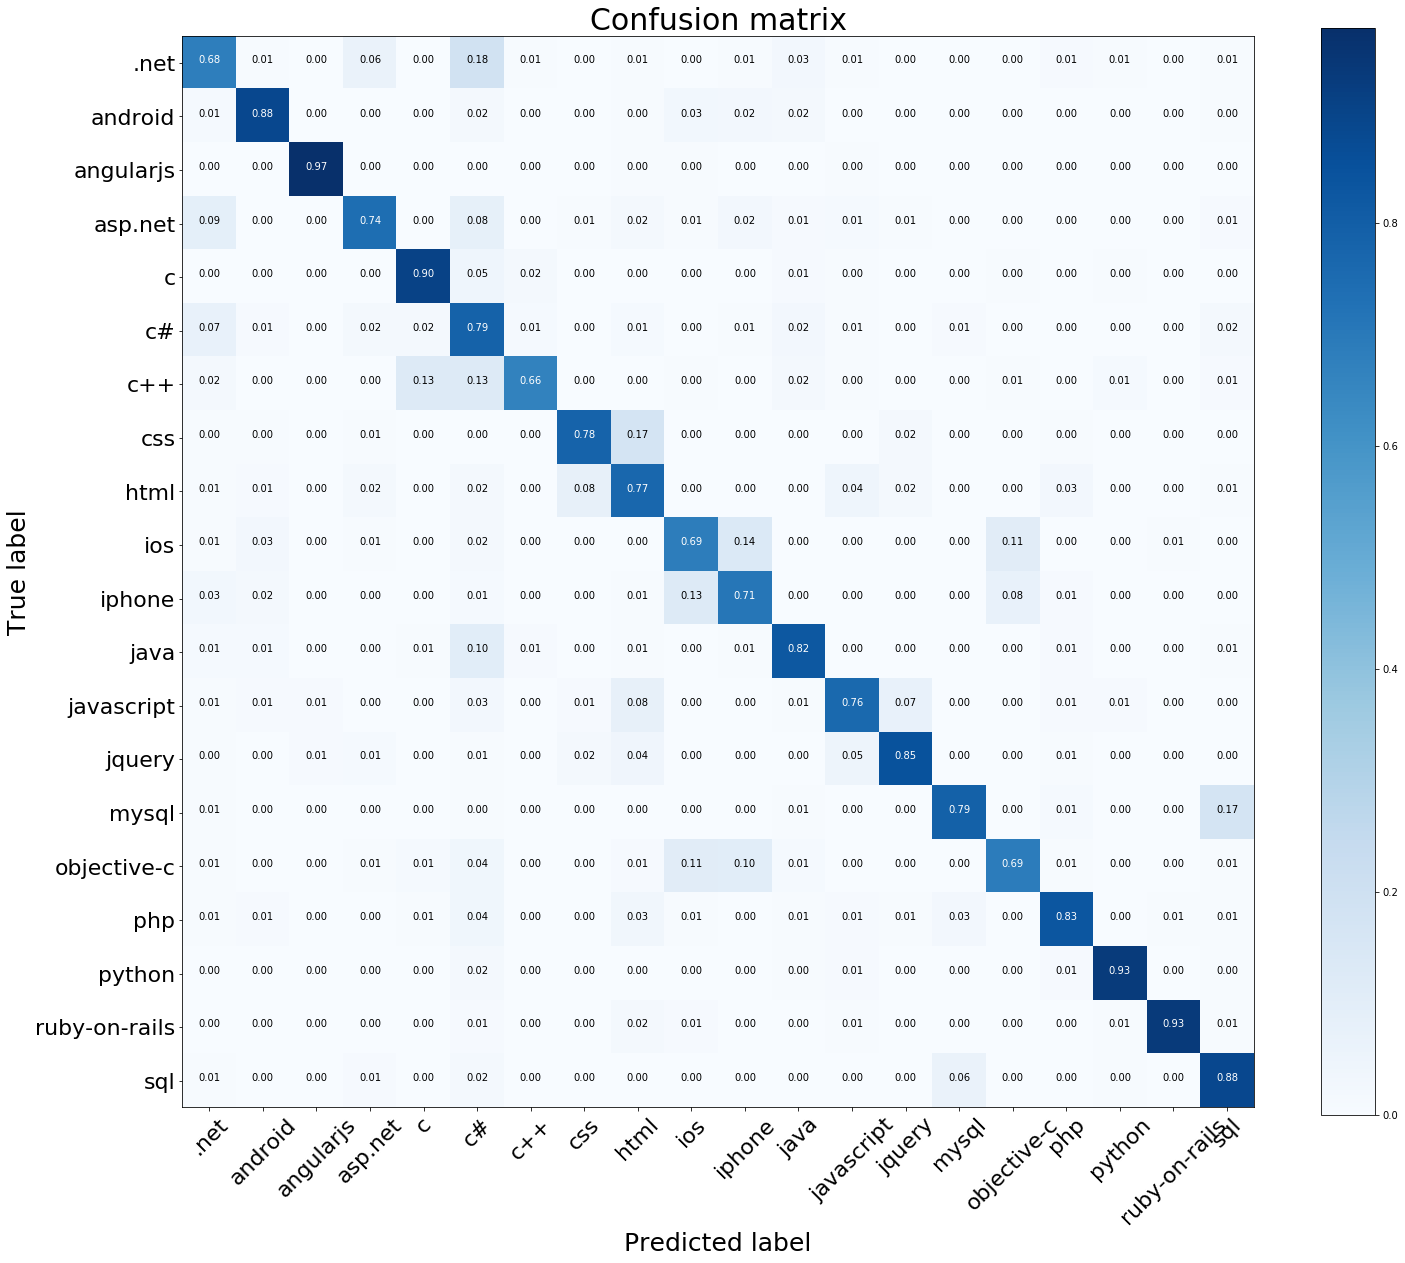

In [21]:
y_softmax = model.predict(x_test)
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_softmax, axis=1))
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [55]:
def make_prediction(text):
    text = tokenize.texts_to_matrix([text])
    prediction = model.predict(text)
    print('Tag: {}'.format(text_labels[np.argmax(prediction)]))

In [59]:
make_prediction('I use more java than python, java is my favorite, so what do you think of java')

Tag: python
